In [109]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn

In [110]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [111]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

In [112]:
feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
print(feeds_df.shape)
feeds_df.head()

(2555, 13)


,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]
1,5eabae544bc32c003663b786,False,5eabad0e9890ea0050e7c800,2020-05-01 05:06:28.767,True,False,0.235294,"Hi guys, I am a chemical Engineer. But my pass...",POST,2020-05-01 09:33:16.347,[],[],[]
2,5eaa94e911914b00283bcaf5,False,5eaa928fd9e8980022200613,2020-04-30 09:05:45.211,True,False,0.888889,@ShitalKakad Which Indian food to include in t...,QUESTION,2020-05-13 02:38:07.669,[],[],[]
3,5eaad78e11914b00283bcb25,False,5ea974f75e00240036a11833,2020-04-30 13:50:06.761,True,False,1.647059,Hello everyone. Looking forward to connect wit...,POST,2020-05-01 08:14:41.114,[],[],[]
4,5eac79d6bfe8020026a3bc63,False,5eac5a685ed505002290ca9b,2020-05-01 19:34:46.428,True,False,0.937500,Hey me Ankita ..I want to get work from home j...,POST,2020-05-17 20:33:23.220,[],[],[]


# Interactions Data

In [113]:
likes_df = pd.read_csv(os.getcwd() + '/Datasets/likes_coll_df.csv')
likes_df['createdAt'] = pd.to_datetime(likes_df['createdAt'])
likes_df['updatedAt'] = pd.to_datetime(likes_df['updatedAt'])
likes_df = likes_df[likes_df['type'] != 'ARTICLE']
print(likes_df.shape)
likes_df.head(1)

(6866, 9)


,likeId,commentId,createdAt,emojiType,isActive,referenceId,type,updatedAt,userId
0,5df502726c5e063edec6360b,5df4b061a68eb700165a664a,2019-12-14 15:40:34.645,Like,True,NaN,COMMENT,2019-12-14 15:40:34.645,5df45b5b7e4ea600161b8ede


In [114]:
comments_df = pd.read_csv(os.getcwd() + '/Datasets/comments_df.csv')
comments_df['createdAt'] = pd.to_datetime(comments_df['createdAt'])
print(comments_df.shape)
comments_df.head(1)

(7241, 8)


,commentId,authorId,createdAt,isActive,isSubComment,referenceId,type,comment_text
0,5df47e0b7e4ea600161b94b3,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,True,False,5df4699b7e4ea600161b913e,QUESTION,Hi Pihu. I strongly believe you should start y...


In [115]:
bookmarks_df = pd.read_csv(os.getcwd() + '/Datasets/bookmarks_coll_df.csv')
bookmarks_df['createdAt'] = pd.to_datetime(bookmarks_df['createdAt'])
bookmarks_df['updatedAt'] = pd.to_datetime(bookmarks_df['updatedAt'])
bookmarks_df = bookmarks_df[bookmarks_df['type'] != 'COMPANY']
print(bookmarks_df.shape)
bookmarks_df.head(1)

(249, 7)


,bookmarkId,createdAt,isActive,referenceFeedId,type,updatedAt,userId
0,5e5e1df0038098664944f081,2020-03-03 09:05:52.348,True,5e5e195568860c00163d49db,POST,2020-03-16 09:37:54.993,5df4c077a68eb700165a66c3


In [116]:
post_likes_df = likes_df[likes_df['type'] != 'COMMENT']
print(post_likes_df.shape)
post_likes_df = post_likes_df[['likeId', 'referenceId', 'userId', 'createdAt', 'type']]
post_likes_df = post_likes_df.rename(columns = {'likeId':'eventId', 'referenceId':'contentId', 'userId':'personId'})
post_likes_df['eventType'] = 'LIKE'

(3749, 9)


In [117]:
likes_df_formatted = post_likes_df
likes_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [118]:
comments_df_formatted = comments_df[['commentId', 'referenceId', 'authorId', 'createdAt', 'type', 'isSubComment']]
comments_df_formatted = comments_df_formatted.rename(columns = {'commentId':'eventId', 'referenceId':'contentId', 'authorId':'personId'})
comments_df_formatted['eventType'] = np.where(comments_df_formatted['isSubComment'] == False, 'COMMENT', 'SUBCOMMENT')
comments_df_formatted = comments_df_formatted.drop(['isSubComment'], axis=1)
comments_df_formatted.head(1)


,eventId,contentId,personId,createdAt,type,eventType
0,5df47e0b7e4ea600161b94b3,5df4699b7e4ea600161b913e,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,QUESTION,COMMENT


In [119]:
bookmarks_df_formatted = bookmarks_df[['bookmarkId', 'referenceFeedId', 'userId', 'createdAt', 'type']]
bookmarks_df_formatted = bookmarks_df_formatted.rename(columns = {'bookmarkId':'eventId', 'referenceFeedId':'contentId', 'userId':'personId'})
bookmarks_df_formatted['eventType'] = 'BOOKMARK'
bookmarks_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
0,5e5e1df0038098664944f081,5e5e195568860c00163d49db,5df4c077a68eb700165a66c3,2020-03-03 09:05:52.348,POST,BOOKMARK


In [120]:
feeds_df.head(1)

,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]


In [121]:
written_post_df_formatted = feeds_df[['contentId', 'authorId', 'createdAt', 'type']].copy()
written_post_df_formatted['eventId'] = written_post_df_formatted['contentId']
written_post_df_formatted = written_post_df_formatted.rename(columns = {'authorId':'personId'})
written_post_df_formatted = written_post_df_formatted[['eventId', 'contentId', 'personId', 'createdAt', 'type']]
written_post_df_formatted['eventType'] = 'CREATE POST'
written_post_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
0,5eaa8499d9e8980022200604,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,POST,CREATE POST


In [122]:
interactions_df = likes_df_formatted.append([comments_df_formatted, bookmarks_df_formatted, written_post_df_formatted])
print(interactions_df.shape)
interactions_df.head(1)

(13794, 6)


,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [123]:
#Removing content from interactions whih are not present in Feed data
interactions_df = interactions_df[interactions_df['contentId'].isin(feeds_df['contentId'])]
print(interactions_df.shape)
interactions_df.head(1)

(13639, 6)


,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [124]:
interaction_summary = interactions_df.groupby(['personId'])['contentId'].nunique().reset_index()
interaction_summary.columns = ['personId', 'content_ct']
interaction_summary = interaction_summary.sort_values(['content_ct'], ascending=False)
print("Total Users:", interaction_summary.shape)
print("Users with more than 1 content interaction:", interaction_summary[interaction_summary['content_ct']>1].shape)
interaction_summary.head(1)


Total Users: (2180, 2)
Users with more than 1 content interaction: (897, 2)


,personId,content_ct
0,5df38de0b2694d0016bdb71f,567


In [125]:
first_interaction = interactions_df.groupby(['personId', 'contentId'])['createdAt'].min().reset_index()
first_interaction['rank'] = first_interaction.groupby(['personId'])['createdAt'].rank(method="first", ascending = False)

content_count = first_interaction.groupby(['personId'])['contentId'].count().reset_index()
content_count.columns = ['personId', 'content_count']

first_interaction = pd.merge(first_interaction, content_count, how = 'left', on = ['personId'])

max_rank = first_interaction.groupby(['personId'])['rank'].max().reset_index()
max_rank.columns = ['personId', 'max_rank']

first_interaction = pd.merge(first_interaction, max_rank, how = 'left', on = ['personId'])
first_interaction['rank_proportion'] = (first_interaction['rank']/first_interaction['max_rank'])*100

first_interaction['interaction_category'] = np.where(first_interaction['content_count'] == 1, 'Single', 'Multi')

first_interaction.head()

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi


In [126]:
first_interaction_multi = first_interaction[first_interaction['interaction_category'] == 'Multi'].copy()

def custom_train_test_func(df):
    if( (df['content_count']<=4) & (df['rank']==1.0) ):
        return('Test')
    if( (df['content_count']>4) & (df['rank_proportion']<=20.00000) & (df['rank']<=10.0) ):
        return('Test')
    else:
        return('Train')

first_interaction_multi['train_test'] = first_interaction_multi.apply(custom_train_test_func, axis=1)
#first_interaction['train_test'] = np.where((first_interaction['interaction_category']=='Multi') & (first_interaction['rank_proportion']<=33.33333), "Test", "Train")
first_interaction_multi.head(5)

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category,train_test
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi,Train
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi,Train
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi,Train
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi,Train
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi,Train


In [127]:
print('Train', first_interaction_multi[first_interaction_multi['train_test']=='Train'].shape)
print('Test', first_interaction_multi[first_interaction_multi['train_test']=='Test'].shape)

Train (7450, 9)
Test (1490, 9)


# Data Wrangling

In [128]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
#   'FOLLOW': 3.0,
   'COMMENT': 4.0,
    'SUBCOMMENT': 4.0,
    'CREATE POST':5
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [129]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 2180
# users with 1 interactions: 1283
# users with at least 2 interactions: 897


In [130]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_multi_inter_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_multi_inter_users_df))

# of interactions: 13639
# of interactions from users with at least 2 interactions: 11787


In [131]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 13639
# of interactions from users with 1 interaction: 1852


In [132]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_multi_df = interactions_from_multi_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_multi_df))
interactions_multi_df.head()

# of unique user/item interactions: 8940


,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


In [133]:
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_single_df))
interactions_single_df.head()

# of unique user/item interactions: 1283


,personId,contentId,eventStrength
0,5df4582e7e4ea600161b8e75,5df45cdc7e4ea600161b8f0f,2.584963
1,5df459377e4ea600161b8e94,5df45c6e7e4ea600161b8efb,2.584963
2,5df45a5c7e4ea600161b8ebd,5df45e207e4ea600161b8f49,2.584963
3,5df45eea7e4ea600161b8f6f,5df45fed7e4ea600161b8fb0,2.584963
4,5df45feb7e4ea600161b8fad,5df461f77e4ea600161b8ff6,2.584963


In [134]:
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()

,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


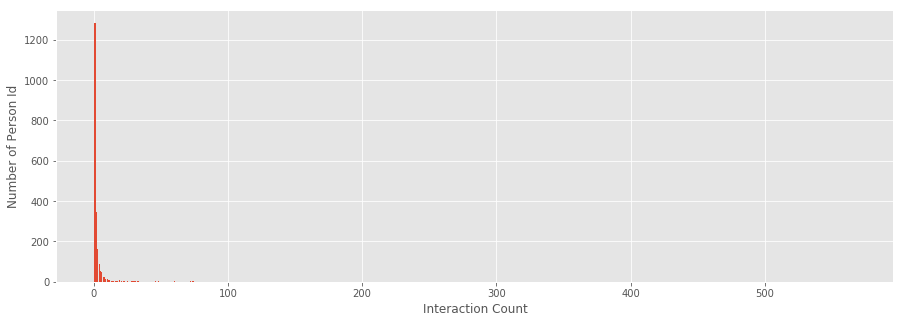

In [135]:
user_interaction_category = users_interactions_count_df.reset_index()
user_interaction_category.columns = ['personId', 'interaction_count']
user_interaction_category.head()

user_interaction_count_summary = user_interaction_category.groupby(['interaction_count'])['personId'].count().reset_index()

%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
plt.bar(user_interaction_count_summary['interaction_count'], user_interaction_count_summary['personId'])
plt.xlabel("Interaction Count")
plt.ylabel("Number of Person Id")
plt.show()

In [136]:
def interaction_category_func(df):
    if(df['interaction_count'] == 1):
        return("1")
    if(df['interaction_count'] == 2):
        return("2")
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return("3 to 5")
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return("6 to 10")
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return("11 to 50")
    if(df['interaction_count'] > 50):
        return("More than 50")
    else:
        return(np.nan)

def interaction_ordering_func(df):
    if(df['interaction_count'] == 1):
        return(1)
    if(df['interaction_count'] == 2):
        return(2)
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return(3)
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return(4)
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return(5)
    if(df['interaction_count'] > 50):
        return(6)
    else:
        return(np.nan)
    
user_interaction_category['interaction_category'] = user_interaction_category.apply(interaction_category_func, axis = 1)
user_interaction_category['order'] = user_interaction_category.apply(interaction_ordering_func, axis = 1)
user_interaction_category.groupby(['order', 'interaction_category'])['personId'].count().reset_index()

,order,interaction_category,personId
0,1,1,1283
1,2,2,345
2,3,3 to 5,307
3,4,6 to 10,121
4,5,11 to 50,88
5,6,More than 50,36


# Evaluation

In [137]:
## Time Bound Sampling

interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction_multi[['personId', 'contentId', 'train_test']], how = 'left', on = ['personId', 'contentId'])
interactions_multi_df_time.head()

interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Train']
interactions_multi_train_df = interactions_multi_train_df.drop(['train_test'], axis=1)

interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Test']
interactions_multi_test_df = interactions_multi_test_df.drop(['train_test'], axis=1)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))


interactions_single_df_time = pd.merge(interactions_single_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
interactions_single_df_time.head()

interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)
interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)
print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


# interactions on Multi Train set: 7450
# interactions on Multi Test set (These are old customers with History): 1490
# interactions on Single Train set: 1050
# interactions on Single Test set (These are new customers with no History): 233


In [30]:
## Time Bound Sampling

#interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction, how = 'left', on = ['personId', 'contentId'])
#interactions_multi_df_time.head()

#interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
#interactions_multi_train_df = interactions_multi_train_df.drop(['createdAt'], axis=1)
#interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
#interactions_multi_test_df = interactions_multi_test_df.drop(['createdAt'], axis=1)
#print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
#print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

#interactions_single_df_time = pd.merge(interactions_single_df, first_interaction, how = 'left', on = ['personId', 'contentId'])
#interactions_single_df_time.head()

#interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
#interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)
#interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
#interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)
#print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
#print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


In [31]:
## Random Sampling
# Take 20% random content as Test. 
# However perform stratified sampling on multi interaction user vs simple sampling for single interaction users
interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_multi_df,
                                   stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
                                   #stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))

# interactions on Multi Train set: 7152
# interactions on Multi Test set (These are old customers with History): 1788
# interactions on Single Train set: 1026
# interactions on Single Test set (These are new customers with no History): 257


In [138]:
#For standardisation of accuracy comparison across users limit the test case content to max 10 for each user
for_N_test_case = interactions_multi_test_df.copy()
for_N_test_case['rank'] = for_N_test_case.groupby(['personId'])['contentId'].apply(lambda x: x.rank())
for_N_test_case = for_N_test_case.sort_values(['personId', 'rank'], ascending = [True, True])

N_test_cases = for_N_test_case[for_N_test_case['rank']<=10].copy()
add_rest_to_train = for_N_test_case[for_N_test_case['rank']>10].copy()

N_test_cases = N_test_cases.drop(['rank'], axis=1)
add_rest_to_train = add_rest_to_train.drop(['rank'], axis=1)

print("N_test_cases: ", N_test_cases.shape)
print("add_rest_to_train: ", add_rest_to_train.shape)

N_test_cases:  (1490, 3)
add_rest_to_train:  (0, 3)


In [139]:
interactions_multi_train_df = interactions_multi_train_df.append(add_rest_to_train)
interactions_multi_test_df = N_test_cases

In [140]:
print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

# interactions on Multi Train set: 7450
# interactions on Multi Test set (These are old customers with History): 1490


In [141]:
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [142]:
#Indexing by personId to speed up the searches during evaluation
#interactions_full_indexed_df = interactions_multi_df.set_index('personId')
#interactions_train_indexed_df = interactions_train_df.set_index('personId')
#interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [143]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')
interactions_multi_train_indexed_df = interactions_multi_train_df.set_index('personId')

In [144]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

In [145]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [146]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [147]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [148]:
#Customisation
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=1000000000)
    person_recs_df['personId'] = person_id
    top_100_reco = person_recs_df[0:100]
    
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10
        

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    hits_at_all_count = sum(pd.Series(list(person_interacted_items_testset)).isin(top_100_reco['contentId']))
    
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
    recall_at_all = hits_at_all_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@all_count':hits_at_all_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@all': recall_at_all,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [149]:
#Customisation
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength', 'createdAt', 'time_since_post', 'recency_rank', 'personId'])
    
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if((pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True) | (pd.Series(person_id).isin(interactions_multi_train_indexed_df.index)[0] == False)):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)  
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
    print('%d users processed' % idx)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_all = detailed_results_df['hits@all_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                        'recall@all': global_recall_at_all}
    
    
    return global_metrics, detailed_results_df, reco_list

In [150]:
recency_df = feeds_df[['contentId', 'createdAt']].copy()
recency_df['time_since_post'] = recency_df['createdAt'].max() - recency_df['createdAt']
recency_df = recency_df.sort_values(['time_since_post'], ascending=True)
recency_df['recency_rank'] = list(range(recency_df.shape[0]))
recency_df.head()

,contentId,createdAt,time_since_post,recency_rank
556,5ec280cec93e790022898ecd,2020-05-18 12:34:22.049,00:00:00,0
523,5ec27d23c93e790022898ec0,2020-05-18 12:18:43.799,00:15:38.250000,1
366,5ec27be54482a4002808c68f,2020-05-18 12:13:25.823,00:20:56.226000,2
540,5ec279f44482a4002808c68d,2020-05-18 12:05:08.660,00:29:13.389000,3
522,5ec27214c93e790022898e8b,2020-05-18 11:31:32.789,01:02:49.260000,4


In [151]:
def recency_of_recommendation_func(all_recommendations):
    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
    return(recommendation_with_recency)

# Popularity Model

In [152]:
#Computes the most popular items
#item_popularity_df = interactions_multi_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#item_popularity_df.head(10)

In [153]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()
#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194


In [154]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        recommendations_df = recency_of_recommendation_func(recommendations_df)


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [155]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...
1129 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2077771329077191, 'recall@10': 0.2919326755658735, 'recall@all': 0.1897852582704585}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,3,2,2,10,Popularity,0.3,0.2,0.2
393,5e85f9294841b100281d4709,4,3,3,10,Popularity,0.4,0.3,0.3
32,5df461787e4ea600161b8fea,1,0,0,10,Popularity,0.1,0.0,0.0
34,5df4623c7e4ea600161b8fff,1,1,1,10,Popularity,0.1,0.1,0.1
43,5df464cd7e4ea600161b907f,1,1,1,10,Popularity,0.1,0.1,0.1


In [156]:
full_reco_list.head()

,contentId,eventStrength,createdAt,time_since_post,recency_rank,personId
0,5ea153885738810038814fcf,61.772765,2020-04-23 08:36:24.829,25 days 03:57:57.220000,810,5df38de0b2694d0016bdb71f
1,5e95945b41a162004c575518,56.989595,2020-04-14 10:45:47.631,34 days 01:48:34.418000,1150,5df38de0b2694d0016bdb71f
2,5e7ee7998735d5002991de15,46.966708,2020-03-28 05:58:49.983,51 days 06:35:32.066000,1649,5df38de0b2694d0016bdb71f
3,5e958b00bdca200024b49ecb,46.186693,2020-04-14 10:05:52.481,34 days 02:28:29.568000,1153,5df38de0b2694d0016bdb71f
4,5e05965154f7880016b75a5f,44.142292,2019-12-27 05:27:45.578,143 days 07:06:36.471000,2061,5df38de0b2694d0016bdb71f


In [157]:
full_reco_list.groupby(['personId'])['contentId'].count().reset_index().head()

,personId,contentId
0,5df38de0b2694d0016bdb71f,10
1,5df431157e4ea600161b8e13,10
2,5df454297e4ea600161b8e25,10
3,5df454d27e4ea600161b8e2a,10
4,5df4561e7e4ea600161b8e3e,10


In [158]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.009784735812133072


In [159]:
def summary_results_func(detailed_results_df, mod_global_metrics):
    detailed_results_df = pd.merge(detailed_results_df, user_interaction_category, how = 'left', left_on = '_person_id', right_on = 'personId')
    detailed_results_df = detailed_results_df.drop(['personId'], axis = 1)
    mod_summary = detailed_results_df.groupby(['order', 'interaction_category']).agg({'_person_id':'count', 'recall@10':'mean', 'recall@5':'mean', 'recall@all':'mean', 'interacted_count':'mean'}).reset_index()
    mod_summary = mod_summary.rename(columns = {'interacted_count':'interacted_in_test_avg'})
    
    overall_summary = pd.DataFrame(index = [0], columns=mod_summary.columns)
    overall_summary['order'] = mod_summary['order'].max()+1
    overall_summary['interaction_category'] = 'Total'
    overall_summary['_person_id'] = mod_summary['_person_id'].sum()
    overall_summary['recall@10'] = mod_global_metrics['recall@10']
    overall_summary['recall@5'] = mod_global_metrics['recall@5']
    overall_summary['recall@all'] = mod_global_metrics['recall@all']
    overall_summary['interacted_in_test_avg'] = sum(mod_summary['interacted_in_test_avg']*mod_summary['_person_id'])/sum(mod_summary['_person_id'])
    final_mod_summary = mod_summary.append(overall_summary)
    return(final_mod_summary)


In [160]:
pop_summary = summary_results_func(pop_detailed_results_df, pop_global_metrics)
pop_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,233,0.347639,0.296137,0.283262,1.000000
1,2,2,345,0.240580,0.176812,0.150725,1.000000
2,3,3 to 5,307,0.328990,0.231270,0.224756,1.000000
3,4,6 to 10,121,0.442149,0.293388,0.276860,1.123967
4,5,11 to 50,88,0.305519,0.216301,0.194030,3.886364
5,6,More than 50,36,0.222222,0.138889,0.113889,10.000000
0,7,Total,1130,0.291933,0.207777,0.189785,1.524779


# Content-Based Filtering model

In [161]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2555x1717 sparse matrix of type '<class 'numpy.float64'>'
	with 51766 stored elements in Compressed Sparse Row format>

In [162]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [163]:
user_profiles = build_users_profiles()
len(user_profiles)

1947

In [164]:
myprofile = user_profiles['5df4c077a68eb700165a66c3']
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['5df4c077a68eb700165a66c3'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1717)


,token,relevance
0,hi,0.175763
1,kool,0.168159
2,community,0.139216
3,help,0.133328
4,work,0.126533
5,everyone,0.125285
6,would,0.124994
7,looking,0.119096
8,kool kanya,0.118459
9,kanya,0.116541


In [165]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]
        
        recommendations_df = recency_of_recommendation_func(recommendations_df)
        
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [166]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [167]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1129 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.20139291932675565, 'recall@10': 0.2716192687173535, 'recall@all': 0.1886244921648288}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,3,2,1,10,Content-Based,0.3,0.2,0.1
393,5e85f9294841b100281d4709,6,5,5,10,Content-Based,0.6,0.5,0.5
32,5df461787e4ea600161b8fea,3,2,1,10,Content-Based,0.3,0.2,0.1
34,5df4623c7e4ea600161b8fff,1,1,0,10,Content-Based,0.1,0.1,0.0
43,5df464cd7e4ea600161b907f,1,0,1,10,Content-Based,0.1,0.0,0.1
253,5e7d8ae72b1c620022131ee5,3,2,2,10,Content-Based,0.3,0.2,0.2
50,5df467277e4ea600161b9109,1,1,1,10,Content-Based,0.1,0.1,0.1
228,5e7c79d8ad47950024ffd1db,0,0,0,10,Content-Based,0.0,0.0,0.0
227,5e7c74cc5e7b37002254c151,3,2,2,10,Content-Based,0.3,0.2,0.2
192,5e783e20ea7e44002251594b,2,0,0,10,Content-Based,0.2,0.0,0.0


In [168]:
temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.25973154362416107 for  897  Users
0.34763948497854075 for  233  Users


In [169]:
cb_summary = summary_results_func(cb_detailed_results_df, cb_global_metrics)
cb_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,233,0.347639,0.296137,0.283262,1.000000
1,2,2,345,0.324638,0.249275,0.223188,1.000000
2,3,3 to 5,307,0.299674,0.221498,0.218241,1.000000
3,4,6 to 10,121,0.235537,0.181818,0.165289,1.123967
4,5,11 to 50,88,0.255885,0.186724,0.174098,3.886364
5,6,More than 50,36,0.200000,0.119444,0.113889,10.000000
0,7,Total,1130,0.271619,0.201393,0.188624,1.524779


In [170]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.8172211350293542


In [171]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
0,5e9abd2768a0cd002f9f0ccc,2020-04-18 08:41:11.263,NaN,5df38de0b2694d0016bdb71f,0.297442,1010,30 days 03:53:10.786000
1,5e7b4cd8a4f3370022656607,2020-03-25 12:21:44.288,NaN,5df38de0b2694d0016bdb71f,0.256523,1769,54 days 00:12:37.761000
2,5e7df03ec3f6090022544818,2020-03-27 12:23:26.449,NaN,5df38de0b2694d0016bdb71f,0.254452,1672,52 days 00:10:55.600000
3,5e7babcdad47950024ffd0a0,2020-03-25 19:06:53.705,NaN,5df38de0b2694d0016bdb71f,0.253900,1756,53 days 17:27:28.344000
4,5e3d5b6e4a2b520016102136,2020-02-07 12:43:26.676,NaN,5df38de0b2694d0016bdb71f,0.252258,1935,100 days 23:50:55.373000


# Collaborative Filtering model

### Matrix Factorization

In [172]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,5df454f37e4ea600161b8e2e,5df4556a7e4ea600161b8e32,5df4558d7e4ea600161b8e36,5df456257e4ea600161b8e41,5df457077e4ea600161b8e53,5df4577e7e4ea600161b8e64,5df457ad7e4ea600161b8e6b,5df458dd7e4ea600161b8e8f,5df459cf7e4ea600161b8eaa,5df459f57e4ea600161b8eb1,...,5ec23d4082d9c700297973b8,5ec24cfc4482a4002808c586,5ec25bf9c93e790022898e3e,5ec25d32c93e790022898e40,5ec25ea74482a4002808c5e6,5ec261e34482a4002808c600,5ec265a1c93e790022898e66,5ec26da64482a4002808c627,5ec27be54482a4002808c68f,5ec280cec93e790022898ecd
personId,,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df431157e4ea600161b8e13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454297e4ea600161b8e25,2.584963,2.584963,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454d27e4ea600161b8e2a,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4561e7e4ea600161b8e3e,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456267e4ea600161b8e43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456497e4ea600161b8e49,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df457557e4ea600161b8e5c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4577c7e4ea600161b8e60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
users_items_pivot_matrix_df.shape

(1947, 2435)

In [174]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.5849625 , 2.5849625 , 2.5849625 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.32192809, 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [175]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['5df38de0b2694d0016bdb71f',
 '5df431157e4ea600161b8e13',
 '5df454297e4ea600161b8e25',
 '5df454d27e4ea600161b8e2a',
 '5df4561e7e4ea600161b8e3e',
 '5df456267e4ea600161b8e43',
 '5df456497e4ea600161b8e49',
 '5df457557e4ea600161b8e5c',
 '5df4577c7e4ea600161b8e60',
 '5df4579f7e4ea600161b8e68']

In [176]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1947x2435 sparse matrix of type '<class 'numpy.float64'>'
	with 8500 stored elements in Compressed Sparse Row format>

In [177]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print("U", U.shape)
print("Vt", Vt.shape)
sigma = np.diag(sigma)
print("sigma", sigma.shape)

U (1947, 20)
Vt (20, 2435)
sigma (20, 20)


In [178]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
print(all_user_predicted_ratings.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

(1947, 2435)


In [179]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,5df38de0b2694d0016bdb71f,5df431157e4ea600161b8e13,5df454297e4ea600161b8e25,5df454d27e4ea600161b8e2a,5df4561e7e4ea600161b8e3e,5df456267e4ea600161b8e43,5df456497e4ea600161b8e49,5df457557e4ea600161b8e5c,5df4577c7e4ea600161b8e60,5df4579f7e4ea600161b8e68,...,5ebfd6b47d2588002321b4d4,5ec0a24a7d2588002321b57e,5ec0fcf39ba71500223e7949,5ec102a082d9c70029797163,5ec114ba9ba71500223e7970,5ec114e982d9c70029797172,5ec184c79ba71500223e7a84,5ec25a6fc93e790022898e38,5ec273a1c93e790022898e99,5ec27bc9c93e790022898ead
contentId,,,,,,,,,,,,,,,,,,,,,
5df454f37e4ea600161b8e2e,0.209888,0.209826,0.209536,0.209381,0.213500,0.211693,0.209420,0.209382,0.210759,0.215024,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209375,0.209378,0.209377,0.209378
5df4556a7e4ea600161b8e32,0.208997,0.209994,0.209922,0.209382,0.211558,0.210606,0.209382,0.209601,0.209305,0.213326,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209377,0.209378,0.209378,0.209378
5df4558d7e4ea600161b8e36,0.209602,0.209447,0.209921,0.209378,0.209494,0.209284,0.209376,0.209397,0.209306,0.209378,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209399,0.209378,0.209378,0.209378
5df456257e4ea600161b8e41,0.210008,0.209572,0.209433,0.209384,0.209216,0.209502,0.209381,0.209430,0.209356,0.209892,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209290,0.209378,0.209377,0.209378
5df457077e4ea600161b8e53,0.211351,0.209561,0.209415,0.209374,0.220149,0.209283,0.209407,0.209739,0.210711,0.211914,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209636,0.209378,0.209379,0.209378
5df4577e7e4ea600161b8e64,0.209366,0.209378,0.209376,0.209378,0.209407,0.209382,0.209379,0.209375,0.209399,0.209384,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209379,0.209378,0.209378,0.209378
5df457ad7e4ea600161b8e6b,0.210914,0.209424,0.209210,0.209377,0.209582,0.210724,0.209388,0.209332,0.209529,0.210850,...,0.209377,0.209378,0.209378,0.209378,0.209378,0.209378,0.209353,0.209378,0.209377,0.209378
5df458dd7e4ea600161b8e8f,0.209141,0.210352,0.209433,0.209389,0.212174,0.211390,0.209389,0.209722,0.209355,0.215535,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209259,0.209378,0.209376,0.209378
5df459cf7e4ea600161b8eaa,0.209583,0.209516,0.209393,0.209378,0.209654,0.209377,0.209376,0.209565,0.209380,0.209634,...,0.209378,0.209378,0.209378,0.209378,0.209378,0.209378,0.209356,0.209378,0.209378,0.209378


In [180]:
len(cf_preds_df.columns)

1947

In [181]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]

        recommendations_df = recency_of_recommendation_func(recommendations_df)
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [182]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1129 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.1787579802669762, 'recall@10': 0.2716192687173535, 'recall@all': 0.1648287869994196}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
393,5e85f9294841b100281d4709,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
32,5df461787e4ea600161b8fea,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
34,5df4623c7e4ea600161b8fff,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
43,5df464cd7e4ea600161b907f,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
253,5e7d8ae72b1c620022131ee5,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
50,5df467277e4ea600161b9109,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
228,5e7c79d8ad47950024ffd1db,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
227,5e7c74cc5e7b37002254c151,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
192,5e783e20ea7e44002251594b,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0


In [183]:
temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.25973154362416107 for  897  Users
0.34763948497854075 for  233  Users


In [184]:
cf_summary = summary_results_func(cf_detailed_results_df, cf_global_metrics)
cf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,233,0.347639,0.296137,0.283262,1.000000
1,2,2,345,0.324638,0.208696,0.194203,1.000000
2,3,3 to 5,307,0.361564,0.211726,0.211726,1.000000
3,4,6 to 10,121,0.355372,0.210744,0.190083,1.123967
4,5,11 to 50,88,0.250099,0.174788,0.141486,3.886364
5,6,More than 50,36,0.097222,0.058333,0.052778,10.000000
0,7,Total,1130,0.271619,0.178758,0.164829,1.524779


In [185]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.2837573385518591


In [186]:
cf_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrength,createdAt,time_since_post,recency_rank
0,5e17112e2d853e0016d15f80,0.779055,2020-01-09 11:40:30.243,130 days 00:53:51.806000,2000
1,5e41010a1022e000161eb0ac,0.642362,2020-02-10 07:06:50.467,98 days 05:27:31.582000,1931
2,5e53b6feba993000169591be,0.635979,2020-02-24 11:43:58.335,84 days 00:50:23.714000,1902
3,5e5e195568860c00163d49db,0.634178,2020-03-03 08:46:13.041,76 days 03:48:09.008000,1888
4,5e18159f18c7770016871d63,0.628409,2020-01-10 06:11:43.898,129 days 06:22:38.151000,1998
5,5e44cb2b18f56700165403c7,0.628078,2020-02-13 04:06:03.043,95 days 08:28:19.006000,1919
6,5e3b8b649f0b4a0016dc081e,0.618025,2020-02-06 03:43:32.614,102 days 08:50:49.435000,1949
7,5e15aba2f70cb800162b780e,0.614690,2020-01-08 10:14:58.379,131 days 02:19:23.670000,2008
8,5e5dd35d9e8fd60016a2d25d,0.601176,2020-03-03 03:47:41.194,76 days 08:46:40.855000,1889
9,5e1e987603561a0016a86ece,0.597842,2020-01-15 04:43:34.952,124 days 07:50:47.097000,1983


In [187]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
0,5ebadc81b657b80028113e01,2020-05-12 17:27:29.439,NaN,5df38de0b2694d0016bdb71f,0.216070,178,5 days 19:06:52.610000
1,5e873a0139bde20029d827bf,2020-04-03 13:28:33.249,NaN,5df38de0b2694d0016bdb71f,0.215597,1395,44 days 23:05:48.800000
2,5e03b7996a0eee0016022749,2019-12-25 19:25:13.279,NaN,5df38de0b2694d0016bdb71f,0.215309,2070,144 days 17:09:08.770000
3,5e0efaffdebe280016de5c85,2020-01-03 08:27:43.758,NaN,5df38de0b2694d0016bdb71f,0.215069,2024,136 days 04:06:38.291000
4,5e7e49df8735d5002991dd4f,2020-03-27 18:45:51.838,NaN,5df38de0b2694d0016bdb71f,0.215058,1665,51 days 17:48:30.211000


### User to User Collaborative Filtering 

In [188]:
user_factor_DF = pd.DataFrame(U)
user_factor_DF.index = users_items_pivot_matrix_df.index
user_factor_DF.columns = ['F'+ str(c) for c in list(range(1,user_factor_DF.shape[1]+1))]
user_factor_DF.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
personId,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.000092,-0.007690,-0.000015,0.008586,0.003814,0.010583,-0.006735,-0.005294,0.001353,0.001048,0.004457,-0.004444,-0.005584,-0.000081,0.010416,-0.034739,0.026183,-0.104414,-0.380109,-0.915707
5df431157e4ea600161b8e13,-0.002502,-0.015022,0.000637,-0.005973,0.008062,-0.006275,-0.002725,-0.009360,-0.011416,0.002046,0.003977,0.001078,-0.012244,-0.015267,-0.007735,0.001424,-0.000676,-0.005385,0.007462,-0.001432
5df454297e4ea600161b8e25,0.002592,-0.007343,-0.008251,-0.005419,-0.010034,0.009532,-0.001270,-0.012227,-0.006806,-0.000385,-0.021357,-0.013469,0.006477,-0.004620,-0.015326,-0.008651,-0.009588,0.003359,0.005609,-0.003529
5df454d27e4ea600161b8e2a,0.000311,-0.000025,-0.000122,0.000047,0.000151,0.000057,-0.000056,0.000137,-0.000218,0.000063,0.000022,-0.000012,-0.000070,-0.000131,-0.000072,-0.000015,0.000016,-0.000023,0.000011,-0.000005
5df4561e7e4ea600161b8e3e,-0.059237,-0.013382,-0.044871,0.012318,-0.063305,0.032902,-0.068437,-0.013159,0.003852,-0.058554,0.070201,0.003672,0.021519,-0.058272,-0.014190,0.021307,0.030877,0.030474,0.026010,-0.021986


In [189]:
user_factor_DF_PID = user_factor_DF.copy()
user_factor_DF_PID['personId'] = user_factor_DF_PID.index
user_factor_DF_PID.index = range(user_factor_DF.shape[0])
user_factor_DF_PID.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F12,F13,F14,F15,F16,F17,F18,F19,F20,personId
0,0.000092,-0.007690,-0.000015,0.008586,0.003814,0.010583,-0.006735,-0.005294,0.001353,0.001048,...,-0.004444,-0.005584,-0.000081,0.010416,-0.034739,0.026183,-0.104414,-0.380109,-0.915707,5df38de0b2694d0016bdb71f
1,-0.002502,-0.015022,0.000637,-0.005973,0.008062,-0.006275,-0.002725,-0.009360,-0.011416,0.002046,...,0.001078,-0.012244,-0.015267,-0.007735,0.001424,-0.000676,-0.005385,0.007462,-0.001432,5df431157e4ea600161b8e13
2,0.002592,-0.007343,-0.008251,-0.005419,-0.010034,0.009532,-0.001270,-0.012227,-0.006806,-0.000385,...,-0.013469,0.006477,-0.004620,-0.015326,-0.008651,-0.009588,0.003359,0.005609,-0.003529,5df454297e4ea600161b8e25
3,0.000311,-0.000025,-0.000122,0.000047,0.000151,0.000057,-0.000056,0.000137,-0.000218,0.000063,...,-0.000012,-0.000070,-0.000131,-0.000072,-0.000015,0.000016,-0.000023,0.000011,-0.000005,5df454d27e4ea600161b8e2a
4,-0.059237,-0.013382,-0.044871,0.012318,-0.063305,0.032902,-0.068437,-0.013159,0.003852,-0.058554,...,0.003672,0.021519,-0.058272,-0.014190,0.021307,0.030877,0.030474,0.026010,-0.021986,5df4561e7e4ea600161b8e3e


In [190]:
class UsertoUserCFRecommender:
    
    MODEL_NAME = 'User-to-User'
    
    def __init__(self, items_df = None):
        self.items_df = items_df
        #self.user_factor_DF = user_factor_DF
        #self.user_factor_DF_PID = user_factor_DF_PID
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_items_by_similar_users(self, person_id, topn=100):
        #Computes the cosine similarity between the users to find similary users
        cosine_similarities = cosine_similarity(np.array(user_factor_DF[user_factor_DF.index==person_id]).reshape(1,-1), np.array(user_factor_DF))
        #Gets the top similar users
        similar_indices = cosine_similarities.argsort().flatten()[-1000:]
        matched_users = user_factor_DF_PID[user_factor_DF_PID.index.isin(pd.Series(similar_indices))]
        matched_users = matched_users[matched_users['personId'] != person_id]
        
        #Sort the similar items by similarity
        top_content = full_interaction_df[full_interaction_df['personId'].isin(matched_users['personId'])]
        top_content = top_content[['contentId', 'eventStrength']].groupby(['contentId'])['eventStrength'].sum().reset_index()
        top_content = top_content.sort_values(['eventStrength'], ascending=False)

        similar_items = top_content.head(topn)
        return similar_items
           
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_items_by_similar_users(user_id)
        # Recommend the items interacted by similar users
        recommendations_df = similar_items[~similar_items['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        recommendations_df = recency_of_recommendation_func(recommendations_df)
        return recommendations_df
u2u_cf_recommender_model = UsertoUserCFRecommender(feeds_df)

In [191]:
print('Evaluating User to User Collaborative Filtering.....')
ucf_global_metrics, ucf_detailed_results_df, full_reco_list = evaluate_model(u2u_cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % ucf_global_metrics)
ucf_detailed_results_df.head(10)

Evaluating User to User Collaborative Filtering.....
1129 users processed

Global metrics:
{'modelName': 'User-to-User', 'recall@5': 0.17121300058038305, 'recall@10': 0.18514219384793965, 'recall@all': 0.17643644805571676}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,User-to-User,0.0,0.0,0.0
393,5e85f9294841b100281d4709,4,4,4,10,User-to-User,0.4,0.4,0.4
32,5df461787e4ea600161b8fea,0,0,0,10,User-to-User,0.0,0.0,0.0
34,5df4623c7e4ea600161b8fff,1,1,1,10,User-to-User,0.1,0.1,0.1
43,5df464cd7e4ea600161b907f,0,0,0,10,User-to-User,0.0,0.0,0.0
253,5e7d8ae72b1c620022131ee5,0,0,0,10,User-to-User,0.0,0.0,0.0
50,5df467277e4ea600161b9109,0,0,0,10,User-to-User,0.0,0.0,0.0
228,5e7c79d8ad47950024ffd1db,2,2,2,10,User-to-User,0.2,0.2,0.2
227,5e7c74cc5e7b37002254c151,0,0,0,10,User-to-User,0.0,0.0,0.0
192,5e783e20ea7e44002251594b,2,2,2,10,User-to-User,0.2,0.2,0.2


In [192]:
temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.1597315436241611 for  897  Users
0.34763948497854075 for  233  Users


In [193]:
ucf_summary = summary_results_func(ucf_detailed_results_df, ucf_global_metrics)
ucf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,233,0.347639,0.296137,0.283262,1.000000
1,2,2,345,0.153623,0.153623,0.153623,1.000000
2,3,3 to 5,307,0.208469,0.195440,0.208469,1.000000
3,4,6 to 10,121,0.252066,0.231405,0.252066,1.123967
4,5,11 to 50,88,0.192830,0.185507,0.192830,3.886364
5,6,More than 50,36,0.077778,0.072222,0.077778,10.000000
0,7,Total,1130,0.185142,0.171213,0.176436,1.524779


In [194]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.023483365949119372


In [195]:
full_reco_list.head()

,contentId,eventStrength,createdAt,time_since_post,recency_rank,personId
0,5e7ee7998735d5002991de15,39.359378,2020-03-28 05:58:49.983,51 days 06:35:32.066000,1649,5df38de0b2694d0016bdb71f
1,5e95945b41a162004c575518,36.597847,2020-04-14 10:45:47.631,34 days 01:48:34.418000,1150,5df38de0b2694d0016bdb71f
2,5e41010a1022e000161eb0ac,31.734125,2020-02-10 07:06:50.467,98 days 05:27:31.582000,1931,5df38de0b2694d0016bdb71f
3,5e05965154f7880016b75a5f,30.965339,2019-12-27 05:27:45.578,143 days 07:06:36.471000,2061,5df38de0b2694d0016bdb71f
4,5e9bfba5cdd65a004b206d5c,28.096695,2020-04-19 07:20:05.103,29 days 05:14:16.946000,970,5df38de0b2694d0016bdb71f


In [196]:
u2u_cf_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,eventStrength,createdAt,time_since_post,recency_rank
0,5eb4f43d63c2df0022d975b8,116.117504,2020-05-08 05:55:09.430,10 days 06:39:12.619000,374
1,5e782cd3ea7e440022515910,89.064947,2020-03-23 03:28:19.038,56 days 09:06:03.011000,1816
2,5eb39dc7854ebb0022622aa0,58.281761,2020-05-07 05:33:59.079,11 days 07:00:22.970000,405
3,5eb64ff240ca75004c486c14,55.512374,2020-05-09 06:38:42.355,9 days 05:55:39.694000,322
4,5ebb8db54b04f6003dd86570,52.089077,2020-05-13 06:03:33.619,5 days 06:30:48.430000,163
5,5ea2c5e5d4abf40029d88e2f,49.985931,2020-04-24 10:56:37.026,24 days 01:37:45.023000,781
6,5ea153885738810038814fcf,46.549593,2020-04-23 08:36:24.829,25 days 03:57:57.220000,810
7,5eb19dc1d97417003de0af80,39.595305,2020-05-05 17:09:21.277,12 days 19:25:00.772000,427
8,5e958b00bdca200024b49ecb,33.729056,2020-04-14 10:05:52.481,34 days 02:28:29.568000,1153
9,5e99839686002400284782d2,30.529985,2020-04-17 10:23:18.400,31 days 02:11:03.649000,1050


### Hybrid Recommendation 

In [197]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        cb_recs_df = cb_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        cf_recs_df = cf_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]

        recommendations_df = recency_of_recommendation_func(recommendations_df)
        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=50.0)


In [198]:
hybrid_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrengthCB,recStrengthCF,recStrengthHybrid,createdAt,time_since_post,recency_rank
0,5e17112e2d853e0016d15f80,0.312138,0.779055,39.264884,2020-01-09 11:40:30.243,130 days 00:53:51.806000,2000
1,5e41010a1022e000161eb0ac,0.219546,0.642362,32.337651,2020-02-10 07:06:50.467,98 days 05:27:31.582000,1931
2,5e5e195568860c00163d49db,0.341172,0.634178,32.050090,2020-03-03 08:46:13.041,76 days 03:48:09.008000,1888
3,5e53b6feba993000169591be,0.000000,0.635979,31.798938,2020-02-24 11:43:58.335,84 days 00:50:23.714000,1902
4,5e18159f18c7770016871d63,0.161987,0.628409,31.582436,2020-01-10 06:11:43.898,129 days 06:22:38.151000,1998
5,5e44cb2b18f56700165403c7,0.146065,0.628078,31.549976,2020-02-13 04:06:03.043,95 days 08:28:19.006000,1919
6,5e3b8b649f0b4a0016dc081e,0.236803,0.618025,31.138037,2020-02-06 03:43:32.614,102 days 08:50:49.435000,1949
7,5e15aba2f70cb800162b780e,0.294331,0.614690,31.028821,2020-01-08 10:14:58.379,131 days 02:19:23.670000,2008
8,5e5dd35d9e8fd60016a2d25d,0.161276,0.601176,30.220068,2020-03-03 03:47:41.194,76 days 08:46:40.855000,1889
9,5e1e987603561a0016a86ece,0.270884,0.597842,30.162968,2020-01-15 04:43:34.952,124 days 07:50:47.097000,1983


In [199]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1129 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.20951828206616366, 'recall@10': 0.2919326755658735, 'recall@all': 0.18514219384793965}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,2,0,0,10,Hybrid,0.2,0.0,0.0
393,5e85f9294841b100281d4709,2,0,0,10,Hybrid,0.2,0.0,0.0
32,5df461787e4ea600161b8fea,1,0,0,10,Hybrid,0.1,0.0,0.0
34,5df4623c7e4ea600161b8fff,0,0,0,10,Hybrid,0.0,0.0,0.0
43,5df464cd7e4ea600161b907f,0,0,0,10,Hybrid,0.0,0.0,0.0
253,5e7d8ae72b1c620022131ee5,0,0,0,10,Hybrid,0.0,0.0,0.0
50,5df467277e4ea600161b9109,0,0,0,10,Hybrid,0.0,0.0,0.0
228,5e7c79d8ad47950024ffd1db,0,0,0,10,Hybrid,0.0,0.0,0.0
227,5e7c74cc5e7b37002254c151,1,0,0,10,Hybrid,0.1,0.0,0.0
192,5e783e20ea7e44002251594b,0,0,0,10,Hybrid,0.0,0.0,0.0


In [200]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.2832214765100671 for  897  Users
0.34763948497854075 for  233  Users


In [201]:
hybrid_summary = summary_results_func(hybrid_detailed_results_df, hybrid_global_metrics)
hybrid_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,233,0.347639,0.296137,0.283262,1.000000
1,2,2,345,0.373913,0.263768,0.228986,1.000000
2,3,3 to 5,307,0.387622,0.280130,0.263844,1.000000
3,4,6 to 10,121,0.334711,0.214876,0.185950,1.123967
4,5,11 to 50,88,0.270301,0.203197,0.165161,3.886364
5,6,More than 50,36,0.113889,0.069444,0.052778,10.000000
0,7,Total,1130,0.291933,0.209518,0.185142,1.524779


In [202]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.6880626223091977


In [203]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post
0,5e873a0139bde20029d827bf,2020-04-03 13:28:33.249,NaN,5df38de0b2694d0016bdb71f,0.193245,0.215597,10.973103,1395,44 days 23:05:48.800000
1,5e7b4cd8a4f3370022656607,2020-03-25 12:21:44.288,NaN,5df38de0b2694d0016bdb71f,0.256523,0.213704,10.941735,1769,54 days 00:12:37.761000
2,5e875e4ed6c7f0004509042a,2020-04-03 16:03:26.019,NaN,5df38de0b2694d0016bdb71f,0.168180,0.214588,10.897596,1390,44 days 20:30:56.030000
3,5e7df03ec3f6090022544818,2020-03-27 12:23:26.449,NaN,5df38de0b2694d0016bdb71f,0.254452,0.212792,10.894041,1672,52 days 00:10:55.600000
4,5eb5154d269e3f004430375b,2020-05-08 08:16:13.357,NaN,5df38de0b2694d0016bdb71f,0.198321,0.213898,10.893206,363,10 days 04:18:08.692000


In [204]:
user_interaction_category.head()

,personId,interaction_count,interaction_category,order
0,5df38de0b2694d0016bdb71f,567,More than 50,6
1,5df431157e4ea600161b8e13,19,11 to 50,5
2,5df454297e4ea600161b8e25,30,11 to 50,5
3,5df454d27e4ea600161b8e2a,2,2,2
4,5df4561e7e4ea600161b8e3e,62,More than 50,6


In [205]:
test = pd.merge(full_reco_list, user_interaction_category, how = 'left', on = 'personId')
test.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post,interaction_count,interaction_category,order
0,5e873a0139bde20029d827bf,2020-04-03 13:28:33.249,NaN,5df38de0b2694d0016bdb71f,0.193245,0.215597,10.973103,1395,44 days 23:05:48.800000,567,More than 50,6
1,5e7b4cd8a4f3370022656607,2020-03-25 12:21:44.288,NaN,5df38de0b2694d0016bdb71f,0.256523,0.213704,10.941735,1769,54 days 00:12:37.761000,567,More than 50,6
2,5e875e4ed6c7f0004509042a,2020-04-03 16:03:26.019,NaN,5df38de0b2694d0016bdb71f,0.168180,0.214588,10.897596,1390,44 days 20:30:56.030000,567,More than 50,6
3,5e7df03ec3f6090022544818,2020-03-27 12:23:26.449,NaN,5df38de0b2694d0016bdb71f,0.254452,0.212792,10.894041,1672,52 days 00:10:55.600000,567,More than 50,6
4,5eb5154d269e3f004430375b,2020-05-08 08:16:13.357,NaN,5df38de0b2694d0016bdb71f,0.198321,0.213898,10.893206,363,10 days 04:18:08.692000,567,More than 50,6


# Comparing Methods

In [206]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, ucf_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5,recall@all
modelName,,,
Content-Based,0.271619,0.201393,0.188624
Popularity,0.291933,0.207777,0.189785
User-to-User,0.185142,0.171213,0.176436
Collaborative Filtering,0.271619,0.178758,0.164829
Hybrid,0.291933,0.209518,0.185142


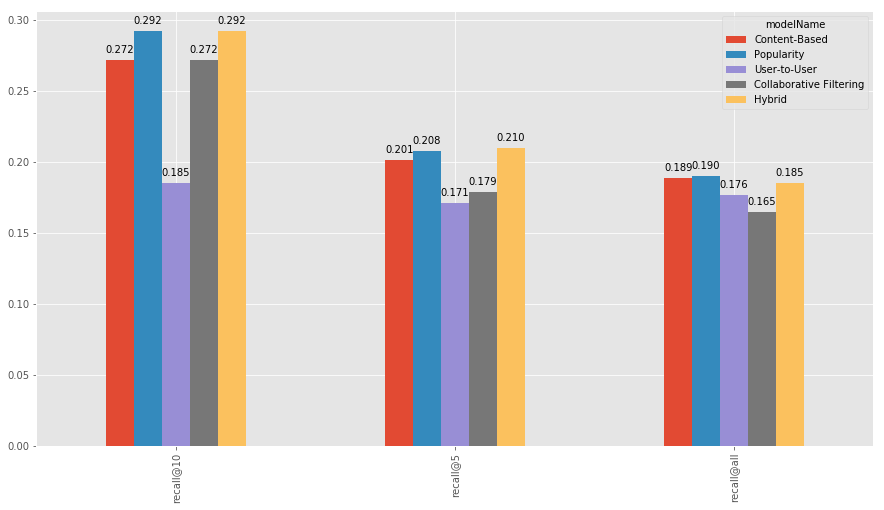

In [207]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [208]:
pop_summary['model'] = 'popularity'
cb_summary['model'] = 'content based'
ucf_summary['model'] = 'user to user'
cf_summary['model'] = 'collaborative filtering'
hybrid_summary['model'] = 'hybrid'

total_summary = pop_summary.append([cb_summary, ucf_summary, cf_summary, hybrid_summary])
total_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg,model
0,1,1,233,0.347639,0.296137,0.283262,1.000000,popularity
1,2,2,345,0.240580,0.176812,0.150725,1.000000,popularity
2,3,3 to 5,307,0.328990,0.231270,0.224756,1.000000,popularity
3,4,6 to 10,121,0.442149,0.293388,0.276860,1.123967,popularity
4,5,11 to 50,88,0.305519,0.216301,0.194030,3.886364,popularity
5,6,More than 50,36,0.222222,0.138889,0.113889,10.000000,popularity
0,7,Total,1130,0.291933,0.207777,0.189785,1.524779,popularity
0,1,1,233,0.347639,0.296137,0.283262,1.000000,content based
1,2,2,345,0.324638,0.249275,0.223188,1.000000,content based
2,3,3 to 5,307,0.299674,0.221498,0.218241,1.000000,content based


In [209]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@10')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.347639,0.347639,0.347639,0.347639,0.347639
2,0.324638,0.324638,0.373913,0.240580,0.153623
3 to 5,0.361564,0.299674,0.387622,0.328990,0.208469
6 to 10,0.355372,0.235537,0.334711,0.442149,0.252066
11 to 50,0.250099,0.255885,0.270301,0.305519,0.192830
More than 50,0.097222,0.200000,0.113889,0.222222,0.077778
Total,0.271619,0.271619,0.291933,0.291933,0.185142


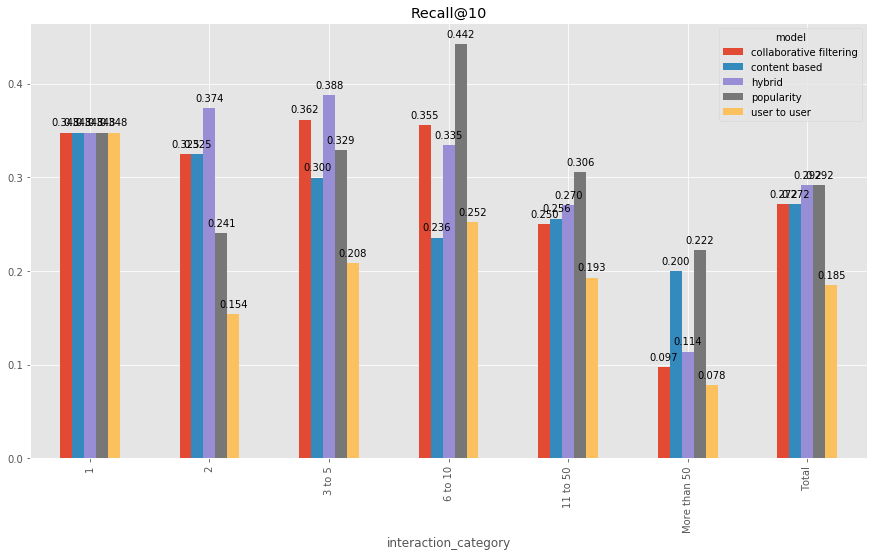

In [210]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@10')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [211]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@all')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.283262,0.283262,0.283262,0.283262,0.283262
2,0.194203,0.223188,0.228986,0.150725,0.153623
3 to 5,0.211726,0.218241,0.263844,0.224756,0.208469
6 to 10,0.190083,0.165289,0.185950,0.276860,0.252066
11 to 50,0.141486,0.174098,0.165161,0.194030,0.192830
More than 50,0.052778,0.113889,0.052778,0.113889,0.077778
Total,0.164829,0.188624,0.185142,0.189785,0.176436


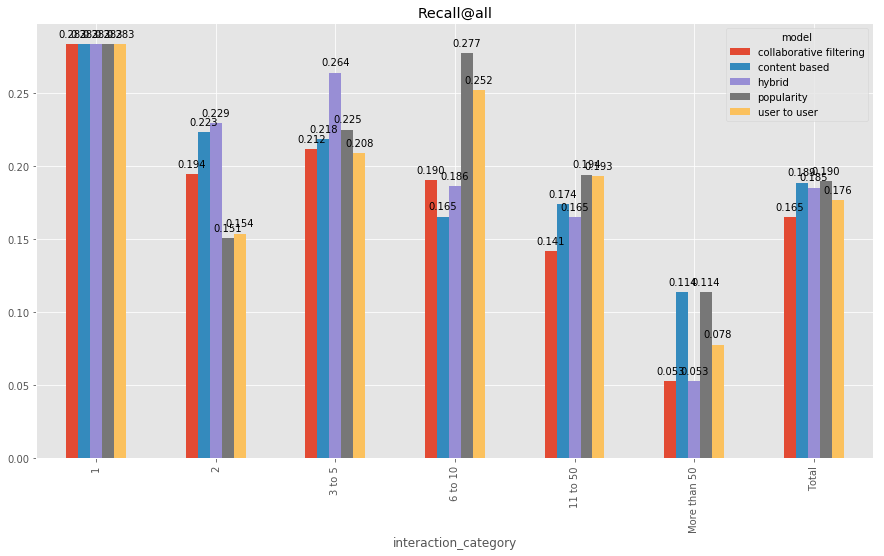

In [212]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@all')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [213]:
popularity_model.recommend_items(user_id = 'dummy', items_to_ignore=[], topn=10, verbose=False)

,contentId,eventStrength,createdAt,time_since_post,recency_rank
0,5eb4f43d63c2df0022d975b8,141.070747,2020-05-08 05:55:09.430,10 days 06:39:12.619000,374
1,5ebb8db54b04f6003dd86570,140.049821,2020-05-13 06:03:33.619,5 days 06:30:48.430000,163
2,5e782cd3ea7e440022515910,117.255353,2020-03-23 03:28:19.038,56 days 09:06:03.011000,1816
3,5ea2c5e5d4abf40029d88e2f,110.661180,2020-04-24 10:56:37.026,24 days 01:37:45.023000,781
4,5eb64ff240ca75004c486c14,81.650041,2020-05-09 06:38:42.355,9 days 05:55:39.694000,322
5,5eb39dc7854ebb0022622aa0,73.061326,2020-05-07 05:33:59.079,11 days 07:00:22.970000,405
6,5eb78f0117e19d00491830ab,65.920599,2020-05-10 05:20:01.904,8 days 07:14:20.145000,296
7,5eb23edc7056fb002fab0c65,65.753619,2020-05-06 04:36:44.064,12 days 07:57:37.985000,425
8,5ea153885738810038814fcf,61.772765,2020-04-23 08:36:24.829,25 days 03:57:57.220000,810
9,5eafced11fd841002e2c9c15,57.071194,2020-05-04 08:14:09.066,14 days 04:20:12.983000,474


In [214]:
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194
